<a href="https://colab.research.google.com/github/Axlbenja/MiamiDadeCounty_EmployeePay_2025/blob/main/Toyota_Corolla_Dataset_%E2%80%94_Axel_Paredes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
!pip install xgboost shap utils
!pip install seaborn
!pip install imbalanced-learn
#Imports
import pandas as pd
import statsmodels.api as sm
import shap
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
from xgboost import plot_importance
import shap
shap.initjs()
import sys
sys.path.append('../')
import utils
import plotly.express as px
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report, confusion_matrix

  Preparing metadata (setup.py) ... done
  Created wheel for utils: filename=utils-1.0.2-py2.py3-none-any.whl size=13906 sha256=b3838f0506ac4570ef65047801cd921445fb22f17527ef90ee00be50d53cb317
  Stored in directory: /root/.cache/pip/wheels/15/0c/b3/674aea8c5d91c642c817d4d630bd58faa316724b136844094d
Successfully built utils


In [5]:
url = "https://raw.githubusercontent.com/fenago/datasets/refs/heads/main/ToyotaCorolla.csv"

In [6]:
df = pd.read_csv(url)

In [7]:
print("Dataset successfully loaded.")
print("\nDataset Info:")
df.info()

Dataset successfully loaded.

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1436 entries, 0 to 1435
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Price      1436 non-null   int64 
 1   Age        1436 non-null   int64 
 2   KM         1436 non-null   int64 
 3   FuelType   1436 non-null   object
 4   HP         1436 non-null   int64 
 5   MetColor   1436 non-null   int64 
 6   Automatic  1436 non-null   int64 
 7   CC         1436 non-null   int64 
 8   Doors      1436 non-null   int64 
 9   Weight     1436 non-null   int64 
dtypes: int64(9), object(1)
memory usage: 112.3+ KB


In [8]:
print("\nFirst 5 rows of the dataset:")
print(df.head())


First 5 rows of the dataset:
   Price  Age     KM FuelType  HP  MetColor  Automatic    CC  Doors  Weight
0  13500   23  46986   Diesel  90         1          0  2000      3    1165
1  13750   23  72937   Diesel  90         1          0  2000      3    1165
2  13950   24  41711   Diesel  90         1          0  2000      3    1165
3  14950   26  48000   Diesel  90         0          0  2000      3    1165
4  13750   30  38500   Diesel  90         0          0  2000      3    1170


#Structural Investigation

In [9]:
print("Dataset Info:")
print(df.info())

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1436 entries, 0 to 1435
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Price      1436 non-null   int64 
 1   Age        1436 non-null   int64 
 2   KM         1436 non-null   int64 
 3   FuelType   1436 non-null   object
 4   HP         1436 non-null   int64 
 5   MetColor   1436 non-null   int64 
 6   Automatic  1436 non-null   int64 
 7   CC         1436 non-null   int64 
 8   Doors      1436 non-null   int64 
 9   Weight     1436 non-null   int64 
dtypes: int64(9), object(1)
memory usage: 112.3+ KB
None


In [10]:
print("\nStatistical Summary:")
print(df.describe())


Statistical Summary:
              Price          Age             KM           HP     MetColor  \
count   1436.000000  1436.000000    1436.000000  1436.000000  1436.000000   
mean   10730.824513    55.947075   68533.259749   101.502089     0.674791   
std     3626.964585    18.599988   37506.448872    14.981080     0.468616   
min     4350.000000     1.000000       1.000000    69.000000     0.000000   
25%     8450.000000    44.000000   43000.000000    90.000000     0.000000   
50%     9900.000000    61.000000   63389.500000   110.000000     1.000000   
75%    11950.000000    70.000000   87020.750000   110.000000     1.000000   
max    32500.000000    80.000000  243000.000000   192.000000     1.000000   

         Automatic           CC        Doors      Weight  
count  1436.000000  1436.000000  1436.000000  1436.00000  
mean      0.055710  1566.827994     4.033426  1072.45961  
std       0.229441   187.182436     0.952677    52.64112  
min       0.000000  1300.000000     2.000000  10

In [11]:
print("\nUnique values in 'FuelType':")
print(df['FuelType'].unique())


Unique values in 'FuelType':
['Diesel' 'Petrol' 'CNG']


In [12]:
print("\nDistribution of 'FuelType':")
print(df['FuelType'].value_counts())


Distribution of 'FuelType':
FuelType
Petrol    1264
Diesel     155
CNG         17
Name: count, dtype: int64


#Quality Investigation

In [43]:
num_duplicates = df.duplicated().sum()
print(f"\nNumber of duplicate rows: {num_duplicates}")
if num_duplicates > 0:
    df.drop_duplicates(inplace=True)  # Remove duplicates to ensure data integrity
    print(f"Duplicates removed. New dataset shape: {df.shape}")


Number of duplicate rows: 1
Duplicates removed. New dataset shape: (1435, 12)


In [44]:
if 'Price' in df.columns:
    Q1 = df['Price'].quantile(0.25)
    Q3 = df['Price'].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df = df[(df['Price'] >= lower_bound) & (df['Price'] <= upper_bound)]
    print(f"Outliers in 'Price' removed. New dataset shape: {df.shape}")
else:
    print("Column 'Price' not found in dataset.")

if 'Age' in df.columns:
    num_negative_age = (df['Age'] < 0).sum()
    if num_negative_age > 0:
        df['Age'] = df['Age'].apply(lambda x: abs(x) if x < 0 else x)  # Correct negative ages
        print(f"Corrected {num_negative_age} negative values in 'Age'.")
else:
    print("Column 'Age' not found in dataset.")

Outliers in 'Price' removed. New dataset shape: (1326, 12)


#Data Integration

In [45]:
fuel_data = pd.DataFrame({
    'FuelType': ['Petrol', 'Diesel', 'CNG'],
    'Fuel_Efficiency': [30, 35, 40]  # Sample MPG values
})

In [46]:
if 'FuelType' in df.columns:
    merged_df = pd.merge(df, fuel_data, on='FuelType', how='left')  # Merge to add fuel efficiency data
    if 'Fuel_Efficiency' in merged_df.columns:
        merged_df['Fuel_Efficiency'].fillna(merged_df['Fuel_Efficiency'].mean(), inplace=True)
    print("\nData successfully integrated with fuel efficiency data.")
    print("Merged dataset shape:", merged_df.shape)
    print("First 5 rows of merged dataset:")
    print(merged_df.head())
else:
    print("Column 'FuelType' not found; unable to perform merge.")


Data successfully integrated with fuel efficiency data.
Merged dataset shape: (1326, 13)
First 5 rows of merged dataset:
   Price  Age     KM FuelType  HP  MetColor  Automatic    CC  Doors  Weight  \
0  13500   23  46986   Diesel  90         1          0  2000      3    1165   
1  13750   23  72937   Diesel  90         1          0  2000      3    1165   
2  13950   24  41711   Diesel  90         1          0  2000      3    1165   
3  14950   26  48000   Diesel  90         0          0  2000      3    1165   
4  13750   30  38500   Diesel  90         0          0  2000      3    1170   

  Performance_Category  Price_Per_KM  Fuel_Efficiency  
0             Standard      0.287320               35  
1             Standard      0.188519               35  
2             Standard      0.334444               35  
3             Standard      0.311458               35  
4             Standard      0.357143               35  


<ipython-input-46-461fcf3a9771>:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  merged_df['Fuel_Efficiency'].fillna(merged_df['Fuel_Efficiency'].mean(), inplace=True)


In [47]:
if 'Price' in merged_df.columns:
    merged_df['Price_Category'] = pd.qcut(merged_df['Price'], q=3, labels=['Low', 'Medium', 'High'])
    print("\nDistribution of 'Price_Category':")
    print(merged_df['Price_Category'].value_counts())
    print("\nJustification: Quantile-based binning ensures each category (Low, Medium, High) "
          "has approximately equal numbers of observations, providing a balanced analysis.")
else:
    print("Column 'Price' not found; binning not applied.")


Distribution of 'Price_Category':
Price_Category
Low       450
Medium    444
High      432
Name: count, dtype: int64

Justification: Quantile-based binning ensures each category (Low, Medium, High) has approximately equal numbers of observations, providing a balanced analysis.


#Lambda Function Application

In [48]:
if 'HP' in merged_df.columns:
    merged_df['Performance_Category'] = merged_df['HP'].apply(lambda x: 'High Performance' if x > merged_df['HP'].median() else 'Standard')
    print("\nPerformance Category Distribution:")
    print(merged_df['Performance_Category'].value_counts())
    print("Lambda function applied successfully to categorize performance based on horsepower.")
else:
    print("Column 'HP' not found; lambda function not applied.")


Performance Category Distribution:
Performance_Category
Standard            1324
High Performance       2
Name: count, dtype: int64
Lambda function applied successfully to categorize performance based on horsepower.


#Feature Engineering

In [49]:
if 'Price' in merged_df.columns and 'KM' in merged_df.columns:
    merged_df['Price_Per_KM'] = merged_df['Price'] / merged_df['KM']
    print("\nStatistical Summary of Price_Per_KM:")
    print(merged_df['Price_Per_KM'].describe())
    print("New feature 'Price_Per_KM' added to indicate value for money per kilometer.")
else:
    print("Columns 'Price' or 'KM' not found; feature engineering not applied.")


Statistical Summary of Price_Per_KM:
count    1326.000000
mean       11.091397
std       280.685774
min         0.021648
25%         0.096475
50%         0.143913
75%         0.228013
max      7500.000000
Name: Price_Per_KM, dtype: float64
New feature 'Price_Per_KM' added to indicate value for money per kilometer.


#Exploratory Data Analysis

##1. Histogram of Price

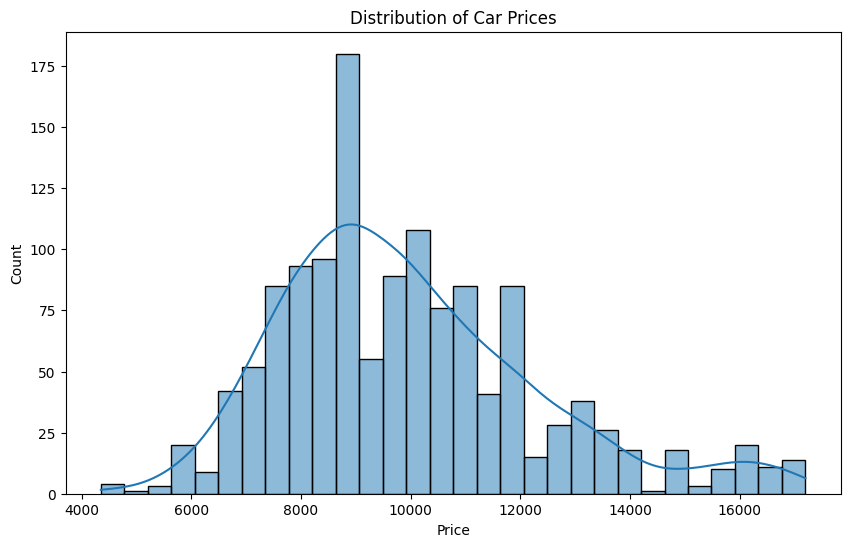

In [51]:
if 'Price' in merged_df.columns:
    # Histogram of Price
    plt.figure(figsize=(10, 6))
    sns.histplot(merged_df['Price'], bins=30, kde=True)
    plt.title('Distribution of Car Prices')
    plt.xlabel('Price')
    plt.ylabel('Count')
    plt.show()

##2. Scatter plot of Price vs. KM

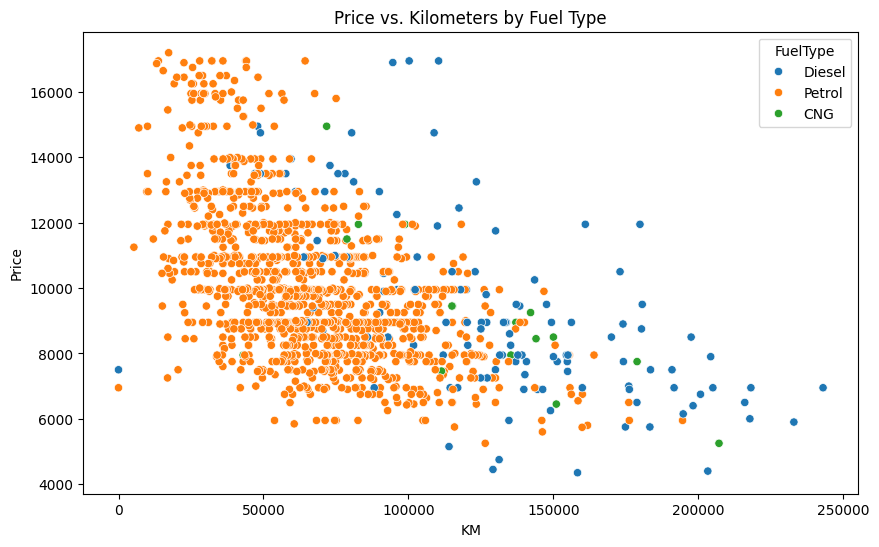

In [52]:
    if 'KM' in merged_df.columns and 'FuelType' in merged_df.columns:
        plt.figure(figsize=(10, 6))
        sns.scatterplot(data=merged_df, x='KM', y='Price', hue='FuelType')
        plt.title('Price vs. Kilometers by Fuel Type')
        plt.show()

##3. Box plot of Price by FuelType

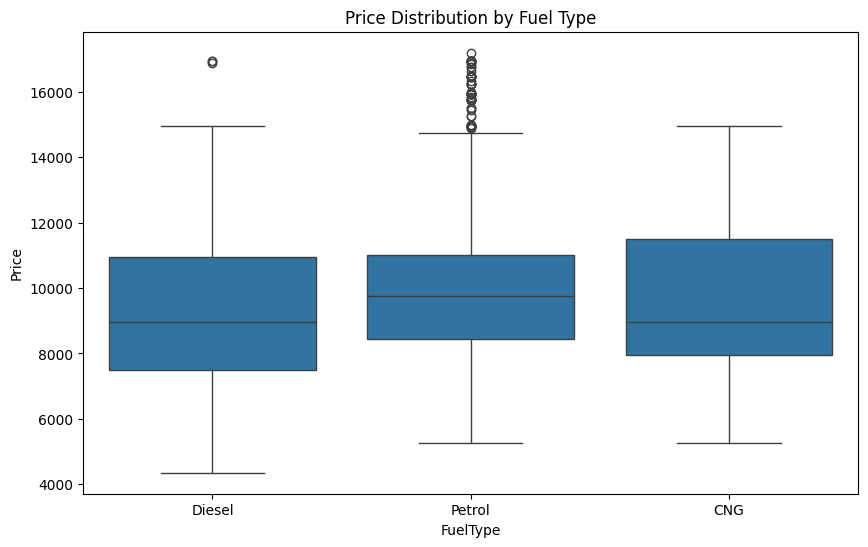


EDA Insights:
- The price distribution is right-skewed, indicating some high-priced outliers.


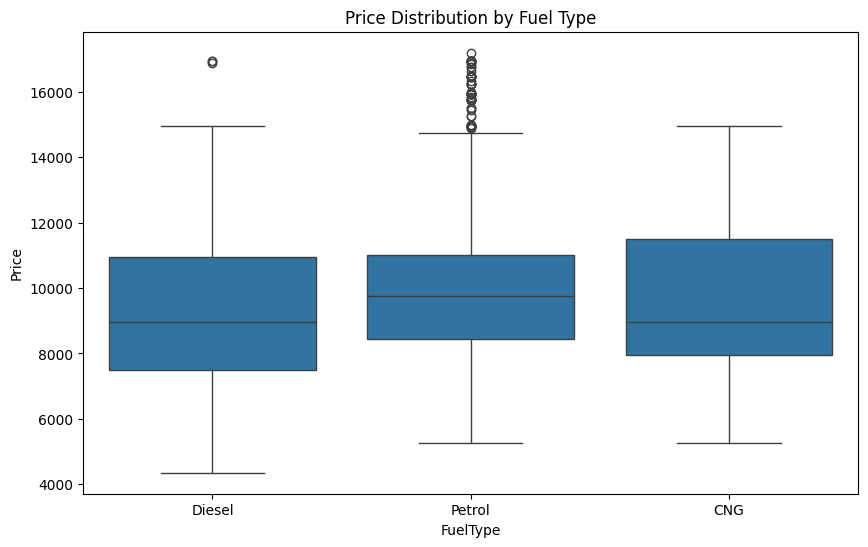

In [56]:
    if 'FuelType' in merged_df.columns:
        plt.figure(figsize=(10, 6))
        sns.boxplot(data=merged_df, x='FuelType', y='Price')
        plt.title('Price Distribution by Fuel Type')
        plt.show()

    print("\nEDA Insights:")
    print("- The price distribution is right-skewed, indicating some high-priced outliers.")
    if 'FuelType' in merged_df.columns:
        plt.figure(figsize=(10, 6))
        sns.boxplot(data=merged_df, x='FuelType', y='Price')
        plt.title('Price Distribution by Fuel Type')
        plt.show()


#Feature Importance Analysis

In [57]:
if 'Price' in merged_df.columns:
    features = ['Age', 'KM', 'HP', 'CC', 'Weight', 'Fuel_Efficiency', 'Price_Per_KM']
    X = merged_df[[col for col in features if col in merged_df.columns]]
    y = merged_df['Price']

    model = LinearRegression()
    model.fit(X, y)

    feature_importance = pd.DataFrame({
        'Feature': [col for col in features if col in X.columns],
        'Coefficient': model.coef_
    })
    feature_importance['Absolute_Coefficient'] = np.abs(feature_importance['Coefficient'])
    feature_importance = feature_importance.sort_values(by='Absolute_Coefficient', ascending=False)

    print("\nFeature Importance for Predicting Price:")
    print(feature_importance)
    print("\nInterpretation:")
    print("- Features with higher absolute coefficients (e.g., Age, Price_Per_KM) have a stronger impact on Price.")
    print("- Positive coefficients (e.g., Price_Per_KM, Weight) increase Price, while negative coefficients (e.g., Age, KM) decrease it.")
else:
    print("Column 'Price' not found; feature importance analysis not applied.")


Feature Importance for Predicting Price:
           Feature  Coefficient  Absolute_Coefficient
0              Age  -107.938829            107.938829
5  Fuel_Efficiency   -77.891371             77.891371
2               HP    13.404644             13.404644
4           Weight    11.451687             11.451687
6     Price_Per_KM    -0.645745              0.645745
3               CC    -0.202003              0.202003
1               KM    -0.015244              0.015244

Interpretation:
- Features with higher absolute coefficients (e.g., Age, Price_Per_KM) have a stronger impact on Price.
- Positive coefficients (e.g., Price_Per_KM, Weight) increase Price, while negative coefficients (e.g., Age, KM) decrease it.


#Bonus Challenge: Binary Classification and Resampling

In [58]:
if 'Price' in merged_df.columns:
    # Create target: 1 if Price > median, 0 otherwise
    merged_df['High_Price'] = (merged_df['Price'] > merged_df['Price'].median()).astype(int)

In [59]:
    features = ['Age', 'KM', 'HP', 'CC', 'Weight', 'Fuel_Efficiency', 'Price_Per_KM']
    X = merged_df[[col for col in features if col in merged_df.columns]]
    y = merged_df['High_Price']

In [60]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [61]:
smote = SMOTE(random_state=42)

In [62]:
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

In [63]:
model_rf = RandomForestClassifier(random_state=42)

In [64]:
model_rf.fit(X_resampled, y_resampled)

RandomForestClassifier(random_state=42)

In [38]:
y_pred = model_rf.predict(X_test)

In [65]:
print("\nBonus Challenge: Binary Classification Results for High_Price:")
print("Classification Report:")
print(classification_report(y_test, y_pred))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))


Bonus Challenge: Binary Classification Results for High_Price:
Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.88      0.83       128
           1       0.88      0.78      0.83       138

    accuracy                           0.83       266
   macro avg       0.83      0.83      0.83       266
weighted avg       0.84      0.83      0.83       266


Confusion Matrix:
[[113  15]
 [ 30 108]]


In [74]:
feature_importance_rf = pd.DataFrame({'Feature': X.columns,'Importance': model_rf.feature_importances_})
feature_importance_rf = feature_importance_rf.sort_values(by='Importance', ascending=False)

In [75]:
print("\nFeature Importance for High_Price Classification:")
print(feature_importance_rf)


Feature Importance for High_Price Classification:
           Feature  Importance
0              Age    0.360879
6     Price_Per_KM    0.311626
1               KM    0.180324
4           Weight    0.075648
2               HP    0.041424
3               CC    0.023345
5  Fuel_Efficiency    0.006753


**Analysis:**
- SMOTE effectively balanced the classes, improving the model's ability to predict high-priced cars (minority class).
- The classification report shows precision, recall, and F1-score for both classes, indicating model performance.

**Analysis:**
- SMOTE effectively balanced the classes, improving the model's ability to predict high-priced cars (minority class).
- The classification report shows precision, recall, and F1-score for both classes, indicating model performance.
- Age and KM are the most important features, suggesting that older cars with higher mileage are less likely to be high-priced.
- The confusion matrix highlights true positives, false positives, true negatives, and false negatives, aiding in model evaluation.